# Description

Notebook to compute metrics.

# Setup

In [1]:
%store -r dic

In [2]:
%matplotlib notebook
%load_ext autoreload

## Imports

In [3]:
# os related
from pathlib import Path
import os 

# data related
import pandas as pd
# import missingno as msno
import datetime as dt
import numpy as np
import json


# visual related
import matplotlib.pyplot as plt
# time related

from fonctions import *

In [4]:
import plotly.graph_objects as go

## Paths

In [5]:

# MUST BE IN CODE FOLDER TO WORK !
PROJECT_PATH = Path(os.getcwd()).parent

RAW_DATA = PROJECT_PATH / "RAW_DATA" 
PROC_DATA = PROJECT_PATH / "PROC_DATA"

# RAW FILES
CSV_FILE = RAW_DATA / "Individual_stock_data_csv.csv"
XLSX_FILE = RAW_DATA / "Individual_stock_data.xlsx"

# PROC FILES
PROC_STOCK = PROC_DATA / "proc_stock.csv"
PROC_CARBON = PROC_DATA / "proc_carbon.csv"

STOCK_2000 = PROC_DATA / "stock_2000.csv"

STOCK_WORK = PROC_DATA / "stock_work.csv"
STOCK2USE = PROC_DATA / "stock2use.csv"
DIC2USE = PROC_DATA / "dic2use.json"


OUT_RENDEMENT = PROC_DATA / "rendement_v1.csv"

OUT_DF_CSV = PROC_DATA / "optimize_assets.csv"
OUT_DF_CSV_CARBON = PROC_DATA / "optimize_assets_carbon_penalty.csv"


# OUT_DIC_WEIGHT = PROC_DATA / "dic_weight.pickle"


DIC_METRICS_CARBON_JSON = PROC_DATA / "dic_metrics_carbon.json"

## Utils

In [6]:
def compute_enc(weights):
    """Function that computes the ENC for given weights an a given window"""
    return 1 / sum([w**2 for w in weights])
    

def compute_ir(excess_return, track_err):
    """Function that computes the information ratio given 
    the excess return and the track_err"""
    return [ex_ret / track_err for (ex_ret, track_err) in zip(excess_return, track_err)]

def compute_di(weight, stock, vol_p):
    """Function that computes the diversification index"""
    stock_vol = stock.std() * np.sqrt(12)
    return np.dot(stock_vol, weight) / (vol_p * np.sqrt(12))

# Notebook


In [7]:
stock_df = read_file(STOCK2USE).iloc[104:-4]

return_df = pd.read_csv(OUT_DF_CSV_CARBON)
return_df.index = read_file(STOCK2USE).index[104:-4]
return_df.drop(columns="Unnamed: 0", inplace=True)

stock_ret = stock_df.pct_change()

sp500 = read_file(STOCK_WORK)
bm_return = equally_weighted(sp500) 

return_sp = pd.DataFrame((sp500.mean(axis=1).pct_change())*100, columns=["mu"])
return_sp = return_sp.loc[return_df.index[0]:return_df.index[-1]]

In [8]:

metrics = ["ret", "vol", "sr", 
           "track_err", "yearly_track_error",
           "ex_ret", "enc", "encb", 
           "ir", "di"]


In [9]:
dic_carbon = dict.fromkeys(return_df.columns)
for k in dic_carbon.keys():
    dic_carbon[k] = dict.fromkeys(metrics)


In [10]:
# Poids pour chacun des rebalancement
dic_weight = {
    pf: pd.read_csv(PROC_DATA / f"carbon_weight_{pf}.csv").rename(columns={'Unnamed: 0':"quarter"}).set_index("quarter")
    for pf in dic_carbon.keys()
}

In [11]:
rf = 0.05

In [115]:
for pf in dic_carbon.keys():
        
    # Rendement annualisé
    dic_carbon[pf]["ret"] = return_df[pf].mean() * 52

    # Volatilité sur les 18 ans
    dic_carbon[pf]["vol"] = return_df[pf].std() * np.sqrt(52)
    
    # Ratio de sharp
    dic_carbon[pf]["sr"] = (dic_carbon[pf]["ret"] - rf) / dic_carbon[pf]["vol"]
    
     # Tracking error
    dic_carbon[pf]["track_err"] = []
    for i in range(len(return_df)//12): # par paquet de 3 mois
        dic_carbon[pf]["track_err"].append((return_df[pf].iloc[i*12:(i+1)*12] - return_sp["mu"].iloc[i*12:(i+1)*12]).std() * np.sqrt(52))
    
    # Tracking global error
    dic_carbon[pf]["yearly_track_err"] = []
    for i in range(len(return_df)//(12*4)): # par paquet de 1 an
        dic_carbon[pf]["yearly_track_err"].append((return_df[pf].iloc[i*12*4:(i+1)*12*4] - return_sp["mu"].iloc[i*12*4:(i+1)*12*4]).std() * np.sqrt(52))
    
    # Excess return 
    dic_carbon[pf]["ex_ret"] = []
    for i in range(len(return_df)//12): # par paquet de 3 mois
        dic_carbon[pf]["ex_ret"].append( 
            52 * (return_df[pf].iloc[i*12:(i+1)*12].mean()) - 52 * (return_sp["mu"].iloc[i*12:(i+1)*12].mean())
        )
        
    # Yearly Excess return 
    dic_carbon[pf]["yearly_ex_ret"] = []
    for i in range(len(return_df)//(12*4)): # par paquet de 1 an
        dic_carbon[pf]["yearly_ex_ret"].append( 
            52 * (return_df[pf].iloc[i*12*4:(i+1)*12*4].mean()) - 52 * (return_sp["mu"].iloc[i*12*4:(i+1)*12*4].mean())
        )

    # Calcul de l'ENC
    dic_carbon[pf]["enc"] = dic_weight[pf].apply(compute_enc, axis=1)
    
    # Information ratio
    dic_carbon[pf]["ir"] = compute_ir(dic_carbon[pf]["ex_ret"], dic_carbon[pf]["track_err"])
        
    # Yearly Information ratio
    dic_carbon[pf]["yearly_ir"] = compute_ir(dic_carbon[pf]["yearly_ex_ret"],
                                             dic_carbon[pf]["yearly_track_err"])
    
    # Diversification index # récupérer les poids
    sum_di = 0
    for i in range(len(return_df)//12):
          sum_di += compute_di(
            weight=dic_weight[pf].iloc[i],
            stock=stock_ret.iloc[i*12:(i+1)*12],
            vol_p=return_df[pf].iloc[i*12:(i+1)*12].std())
            
    print(pf)
    print(sum_di)
    dic_carbon[pf]["di"] = sum_di / (len(return_df)//12)
    
         

ew
1.5161281619472564
gmv
0.9746394930061408
maxdecor
1.066773835115422
maxdiv
1.139102841121276
msr
0.9136819064496173


In [116]:
%store -r dic

In [117]:
for pf in dic_carbon.keys():
    print(pf)
    print(dic_carbon[pf]["di"])

ew
0.01943754053778534
gmv
0.012495378115463343
maxdecor
0.013676587629684897
maxdiv
0.014603882578477898
msr
0.011713870595507915


# Analyse

<IPython.core.display.Javascript object>


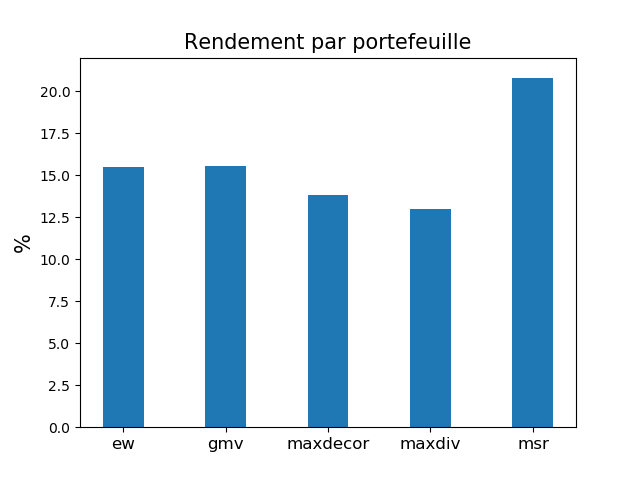

(array([ 0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. , 22.5]),
 <a list of 10 Text yticklabel objects>)

In [118]:
plt.figure()
plt.bar(dic_carbon.keys(),
    [dic_carbon[k]["ret"] for k in dic_carbon.keys()],
       align="center",
        width=0.4
   )

plt.title("Rendement par portefeuille", fontsize=15)
plt.ylabel("%", fontsize=15)
plt.ylim(0,22)

plt.xticks(fontsize=12)
plt.yticks(fontsize=10)

<IPython.core.display.Javascript object>


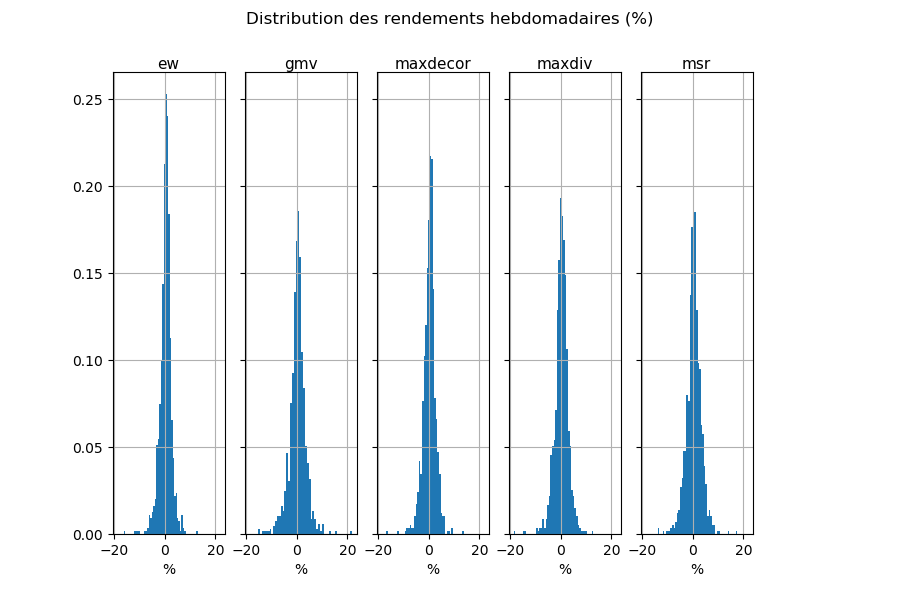

Text(0.5, 0.98, 'Distribution des rendements hebdomadaires (%)')

In [83]:
fig, axs = plt.subplots(1, len(dic_carbon.keys())+1, sharex=True, 
                        sharey=True,
                        figsize=(9, 6),
                        gridspec_kw={"width_ratios": [3, 3, 3, 3, 3, 1]})

dic_carbon_color = {'increasing':'green', 'decreasing':'red', 'no trend':'blue'}


labels = list(dic_carbon.keys())

for i, col in enumerate(return_df.columns):
    axs[i].hist(return_df[col], bins=50, density=True)
    axs[i].set_xlabel("%")
    axs[i].set_title(col, fontsize=11, pad=0.5)
    axs[i].grid(True)
    

    
lax = axs[-1]
lax.axis('off')
# lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in dic_carbon_color.values()]
#lax.legend(lines, labels, loc=10, fontsize=9)

# ----------------

fig.suptitle("Distribution des rendements hebdomadaires (%)")
#fig.suptitle("From {} to {})".format(start, end))
#fig.tight_layout(rect=[0,0,1,0.98])

<IPython.core.display.Javascript object>


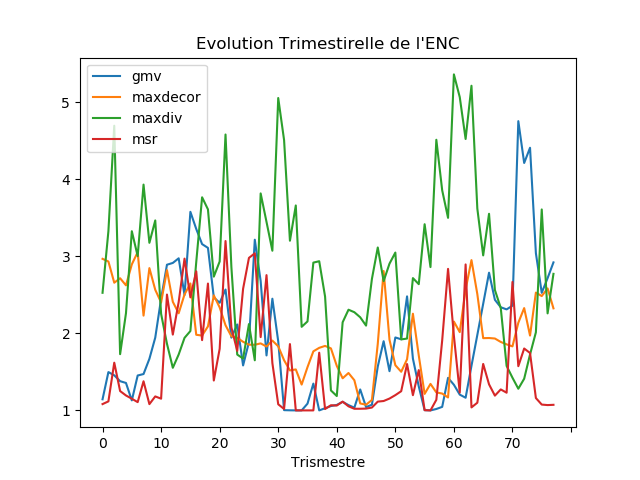

Text(0.5, 0, 'Trismestre')

In [84]:
yr_idx = [str(i) for i in range(len(dic_carbon["ew"]["enc"]))]

enc_df = pd.DataFrame(index=yr_idx)

for k in list(dic_carbon.keys())[1:]:
    enc_df[k] = dic_carbon[k]["enc"].values
    
    

enc_df.plot()    
plt.title("Evolution Trimestirelle de l'ENC")
plt.xlabel("Trismestre")

In [125]:
kpi_list = ["ret", "enc", "vol", "ex_ret", "track_err", "yearly_ir", "sr"]


In [126]:
compare_df = pd.DataFrame(index=kpi_list, columns=["carbon", "no_carbon"])


dic_compare = {}
for k in dic.keys():
    for kpi in kpi_list:
        compare_df["no_carbon"].loc[kpi] = float(np.mean(dic[k][kpi]))
        compare_df["carbon"].loc[kpi] = float(np.mean(dic_carbon[k][kpi]))
    dic_compare[k] = compare_df.astype("float")

In [127]:
dic_compare["maxdiv"].style.background_gradient(cmap="Blues", axis=0)

,carbon,no_carbon
ret,12.990209,12.305293
enc,2.836798,3.123940
vol,19.691088,20.128499
ex_ret,1.251841,0.566925
track_err,17.364173,17.344813
yearly_ir,0.105626,0.012452
sr,0.657161,0.608853


In [128]:
compare_df = pd.DataFrame(index=["carbon_penalty", "no_carbon_penalty"], columns=kpi_list)


dic_compare = {}
for k in dic.keys():
    for kpi in kpi_list:
        compare_df[kpi].loc["no_carbon_penalty"] = float(np.mean(dic[k][kpi]))
        compare_df[kpi].loc["carbon_penalty"] = float(np.mean(dic_carbon[k][kpi]))
    dic_compare[k] = compare_df.astype("float")
    

In [129]:
dic_compare["gmv"].style.background_gradient(cmap="Blues", axis=0)


,ret,enc,vol,ex_ret,track_err,yearly_ir,sr
carbon_penalty,15.576038,1.945766,23.489241,3.837670,17.618907,0.131412,0.660985
no_carbon_penalty,15.768674,1.928022,23.555238,4.030307,17.594026,0.141298,0.667311


In [130]:
dic_compare["maxdecor"].style.background_gradient(cmap="Blues", axis=0)


,ret,enc,vol,ex_ret,track_err,yearly_ir,sr
carbon_penalty,13.838655,2.023594,17.943917,2.100287,15.967680,0.100362,0.768431
no_carbon_penalty,10.074823,5.117514,19.570433,-1.663544,14.766303,-0.093714,0.512243


In [131]:
dic_compare["maxdiv"].style.background_gradient(cmap="Blues", axis=0)

,ret,enc,vol,ex_ret,track_err,yearly_ir,sr
carbon_penalty,12.990209,2.836798,19.691088,1.251841,17.364173,0.105626,0.657161
no_carbon_penalty,12.305293,3.123940,20.128499,0.566925,17.344813,0.012452,0.608853


In [132]:
dic_compare["msr"].style.background_gradient(cmap="Blues", axis=0)

,ret,enc,vol,ex_ret,track_err,yearly_ir,sr
carbon_penalty,20.779256,1.568620,21.554946,9.040888,18.449894,0.432952,0.961694
no_carbon_penalty,12.305293,1.568680,20.128499,0.566925,17.344813,0.012452,0.608853
